# Deep Learning - Lab Exercise 2

**WARNING:** you must have finished the first exercise before this one as you will re-use parts of the code.

In the first lab exercise, we built a simple linear classifier.
Although it can give reasonable results on the MNIST dataset (~92.5% of accuracy), deeper neural networks can achieve more the 99% accuracy on this dataset.
However, it can quickly become really impractical to explicitly code forward and backward passes.
Hence, it is useful to rely on an auto-diff library where we specify the forward pass only, and the backward pass is automatically deduced from the computational graph structure.

In this lab exercise, we will build a small and simple auto-diff lib that mimics the autograd mechanism from Pytorch (of course, we will simplify a lot!)
There is two goal:
- write the missing code
- understand the general structure of an auto-diff lib by looking closely at the code. It will help you to understand how Pytorch works!

In [1]:
# import libs that we will use
import os
import numpy as np
import matplotlib.pyplot as plt
import math

# To load the data we will use the script of Gaetan Marceau Caron
# You can download it from the course webiste and move it to the same directory that contains this ipynb file
import dataset_loader

%matplotlib inline

# Data

In [2]:
# Download mnist dataset 
if("mnist.pkl.gz" not in os.listdir(".")):
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

In [3]:
# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

label: 4


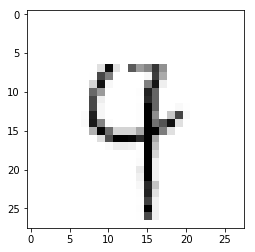

In [4]:
index = 900
label = train_data[1][index]
picture = train_data[0][index]

print("label: %i" % label)
plt.imshow(picture.reshape(28,28), cmap='Greys')

# Computation nodes

Instead of directly manipulating numpy arrays, we will manipulate abstraction that contains:
- a value (i.e. a numpy array)
- a bool indicating if we wish to compute the gradient with respect to the value
- the gradient with respect to the value
- the operation to call during backpropagation

There will be two kinds of nodes:
- Tensor: a generic computation node
- Parameter: a computation node that is used to store parameters of the network. Parameters are always leaf nodes, i.e. they cannot be build from other computation nodes.

Our implementation of the backward pass will be really simple and inefficient in the general case.
We will just apply the derivative function for a given tensor and then call the ones of its antecedents, recursively.
This simple algorithm is good enough for this exercise.
You may want to look at the implementation of the relu (given below) to understand what you have to do.

Note that a real implementation of backprop will store temporary values during forward that can be used during backward to improve computation speed. We do not do that here.

**Report bonus:** give an example of computation graph for which this simple backprop implementation will be inefficient.

In [5]:
class Tensor:
    def __init__(self, data, require_grad=False):
        # test type of data: should be np array
        if isinstance(data, float):
            data = np.array([data,])
        if type(data) != np.ndarray:
            raise RuntimeError("Input should be a numpy array")

        # store data for this tensor
        self.data = data
        self.require_grad = require_grad
        
        # this values should be set to enable autograd!
        self.gradient = None
        self.d = None
        self.backptr = None
        
    def zero_grad(self):
        """
        Set the gradient of thie tensor to 0
        """
        if self.require_grad:
            self.gradient = np.zeros_like(self.data)
            
    def accumulate_gradient(self, gradient):
        """
        Accumulte gradient for this tensor
        """
        if gradient.shape != self.data.shape:
            raise RuntimeError("Invalid gradient dimension")

        if self.gradient is None:
            self.gradient = np.copy(gradient)
        else:
            self.gradient += gradient
            
    def backward(self, g=None):
        """
        The backward pass!
        If g != None, then g is the gradient for the current node.
        i.e. g will be != None only for the loss output.
        
        You should call the function stored in self.d with correct arguments,
        and then recursively call the backward methods of tensors in the backptr list if:
        1. they require a gradient
        2. they are of type Tensor: check with isinstance(o, Tensor)
        """
        if not self.require_grad:  # stop right now if this node does not require a gradient
            return
        
        if g is not None:
            if isinstance(g, float):
                g = np.array([g])
            if type(g) != np.ndarray:
                raise RuntimeError("Gradient should be a numpy array")
            if g.shape != self.data.shape:
                raise RuntimeError("Gradient of different size than the value!")
                
            self.gradient = g
        
        # TODO
        self.d(self.backptr, self.gradient)
        if self.backptr is None:
            return
        else :
            for backptr in self.backptr:
                if not isinstance(backptr, Parameter) and isinstance(backptr, Tensor):
                    backptr.backward()
    
    
class Parameter(Tensor):
    """
    This class will be used to store parameters of the network only!
    """
    def __init__(self, data, name="unamed"):
        super().__init__(data, require_grad=True)
        self.name = name
        self.gamma = np.zeros_like(self.data)
        
    def backward(self):
        raise RuntimeError("You cannot backprop from a Parameter node")

# Functions

Functions manipulate tensors and build the required information for autograd.
A function returns a Tensor that should have require_grad = True if at least of the arguments require a gradient.

In [6]:
def any_require_grad(l):
    """
    Input:
    - l: an iterable (e.g. a list)
    Ouput:
    - True if any tensor in the input requires a gradient
    """
    return any(t.require_grad for t in l)

In [7]:
# Here is an exemple with the ReLU
def relu(x):
    v = np.maximum(0, x.data)
    
    output = Tensor(v, require_grad=x.require_grad)
    output.d = backward_relu
    output.backptr = [x]
    
    return output

def backward_relu(backptr, g):
    x, = backptr
    
    # the gradient is accumulated in the arguments only if required
    if x.require_grad:
        x.accumulate_gradient(g * (x.data > 0))

In [8]:
#TODO
def tanh(x):
    v = np.tanh(x.data)
    
    output = Tensor(v, require_grad=x.require_grad)
    output.d = backward_tanh
    output.backptr = [x]
    
    return output

def backward_tanh(backptr, g):
    x, = backptr
    
    # the gradient is accumulated in the arguments only if required
    if x.require_grad:
        x.accumulate_gradient(g*(1-np.power(np.tanh(x.data),2)))

Next, we implement the affine transform operation.
You can reuse the code from the first lab exercise, with one difference: you have to compute the gradient with respect to x too!

In [9]:
def affine_transform(W, b, x):
    v = W.data @ x.data + b.data
    
    output = Tensor(v, require_grad=any_require_grad([W, b, x]))
    output.d = backward_affine_transform
    output.backptr = [W, b, x]
    
    return output


def backward_affine_transform(backptr, g):
    # retrieve forward arguments
    W, b, x = backptr
    
    # the gradient is accumulated in the arguments only if required
    if W.require_grad:
        W.accumulate_gradient(g.reshape(-1,1) @ np.transpose(x.data.reshape((-1,1))))
    if b.require_grad:
        b.accumulate_gradient(g)
    if x.require_grad:
        #print(W.data.shape, b.data.shape, x.data.shape, g.shape)
        x.accumulate_gradient(g @ W.data ) 

In [10]:
# we use an underscore because this function does not manipulate tensors:
# it is exactly the same as in the previous exercise
def _softmax(x):
    # TODO
    b = max(x)
    y = np.exp(x - b)
    return y / y.sum()


def nll(x, gold):
    # TODO
    v = - x.data[gold] + np.log(np.exp(x.data).sum()) 
    
    output = Tensor(v, require_grad=x.require_grad)
    output.d = backward_nll
    output.backptr = [x]

    return output


def backward_nll(backptr, gold_label, g):
    #TODO
    x, = backptr
    
    if x.require_grad:
        gx = _softmax(x.data)
        
        gx[gold_label]-= 1
        x.accumulate_gradient(g * gx)
        x.backward()

# Module

Neural networks or parts of neural networks will be stored in Modules.
They implement method to retrieve all parameters of the network and subnetwork.

In [11]:
class Module:
    def __init__(self):
        raise NotImplemented("")
        
    def parameters(self):
        ret = []
        for name in dir(self):
            o = self.__getattribute__(name)

            if type(o) is Parameter:
                ret.append(o)
            if isinstance(o, Module) or isinstance(o, ModuleList):
                ret.extend(o.parameters())
        return ret

# if you want to store a list of Parameters or Module,
# you must store them in a ModuleList instead of a python list,
# in order to collect the parameters correctly
class ModuleList(list):
    def parameters(self):
        ret = []
        for m in self:
            if type(m) is Parameter:
                ret.append(m)
            elif isinstance(m, Module) or isinstance(m, ModuleList):
                ret.extend(m.parameters())
        return ret

# Initialization and optimization

In [12]:
def zero_init(b):
    b[:] = 0.

def glorot_init(W):
    dim_output, dim_input = W.shape
    a = np.sqrt(6/(dim_output+dim_input))
    W[:] = np.random.uniform(-a, a, W.shape)

# Look at slides for the formula!
def kaiming_init(W):
    dim_output, dim_input = W.shape
    a = np.sqrt(6/dim_input)
    W[:] = np.random.uniform(-a, a, W.shape)

In [13]:
# simple gradient descent optimizer
class SGD:
    def __init__(self, params, lr=0.1):
        self.params = params
        self.lr = lr
        
    def step(self):
        for p in self.params:
            p.data[:] = p.data - self.lr * p.gradient
        
    def zero_grad(self):
        for p in self.params:
            p.zero_grad()

# Networks and training loop

We first create a simple linear classifier, similar to the first lab exercise.

In [14]:
class LinearNetwork(Module):
    def __init__(self, dim_input, dim_output):
        # build the parameters
        self.W = Parameter(np.ndarray((dim_output, dim_input)))
        self.b = Parameter(np.ndarray((dim_output,)))
        
        self.init_parameters()
        
    def init_parameters(self):
        # init parameters of the network (i.e W and b)
        glorot_init(self.W.data)
        zero_init(self.b.data)        
        
    def forward(self, x):
        return  affine_transform(self.W, self.b, x)

We will train several neural networks.
Therefore, we encapsulate the training loop in a function.

**warning**: you have to call optimizer.zero_grad() before each backward pass to reinitialize the gradient of the parameters!

In [15]:
def training_loop(network, optimizer, train_data, dev_data, n_epochs=10):
    # TODO!!!
    cor_dev_list = []
    cor_train_list = []

    ### Computing the train accuracy before training
    cor_train = 0
    for i in range(len(train_data[0])):
            
            data = train_data[0][i]
            label = train_data[1][i]
            
            tensor = network.forward(Tensor(data))    
            if (np.argmax(tensor.data) == label):
                cor_train += 1
    accuracy_train = cor_train / len(train_data[0])
            
    cor_train_list.append(accuracy_train)            
    print("Before training accuracy is : " ,accuracy_train)

    ### COMPUTING THE RESULTS OF THE NETWORK ON TRAINING DATA WITHOUT TRAINING
    cor_dev = 0
    for i in range(len(dev_data[0])):
        data = dev_data[0][i]
        label = dev_data[1][i]
        tensor = network.forward(Tensor(data))
        if (np.argmax(tensor.data) == label):
            cor_dev += 1
    accuracy_dev = cor_dev / len(dev_data[0])
    cor_dev_list.append(accuracy_dev)
    print("Accuracy on dev data before training is : %f" %(accuracy_dev))
    
    print("-----------------------")
    for epoch in range(n_epochs):
        cor_train = 0
        for i in range(len(train_data[0])):
            data = train_data[0][i]
            label = train_data[1][i]                        
            
            tensor = network.forward(Tensor(data))
            loss = nll(tensor, label)
            
            optimizer.zero_grad()
            backward_nll(loss.backptr, label , g=1.)
            optimizer.step()
            
            if(np.argmax(tensor.data) == label):
                cor_train += 1
    
        # Evaluate the model on the dev set
        cor_dev  = 0
        for i in range(len(dev_data[0])):
            data = dev_data[0][i]
            label = dev_data[1][i]
            tensor = network.forward(Tensor(data))
            if (np.argmax(tensor.data) == label):
                cor_dev += 1
        
        train_accuracy = cor_train/len(train_data[0])
        dev_accuracy = cor_dev/len(dev_data[0])
        cor_dev_list.append(dev_accuracy)
        cor_train_list.append(train_accuracy)
        print("For epoch = %d : Train accuracy is %f and Dev accuracy is %f" %(epoch + 1, train_accuracy, 
                                                                               dev_accuracy))
    print("----------------------------")
    # Evaluate the model on the test set
    cor_test  = 0
    for i in range(len(test_data[0])):
        data = test_data[0][i]
        label = test_data[1][i]
        tensor = network.forward(Tensor(data))
        if (np.argmax(tensor.data) == label):
            cor_test += 1 
    test_accuracy = cor_test/len(test_data[0])
    print("Accuracy on test data is %f "%(test_accuracy))
    
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy in terms of epochs")
    plt.plot([i for i in range(len(cor_dev_list))], cor_dev_list, label = "dev accuracy")
    plt.plot([i for i in range(len(cor_train_list))], cor_train_list, label = "train accuracy")

Before training accuracy is :  0.0715
Accuracy on dev data before training is : 0.073000
-----------------------
For epoch = 1 : Train accuracy is 0.893000 and Dev accuracy is 0.916100
For epoch = 2 : Train accuracy is 0.911780 and Dev accuracy is 0.916000
For epoch = 3 : Train accuracy is 0.915620 and Dev accuracy is 0.918200
For epoch = 4 : Train accuracy is 0.917860 and Dev accuracy is 0.918300
For epoch = 5 : Train accuracy is 0.919380 and Dev accuracy is 0.919800
----------------------------
Accuracy on test data is 0.916800 


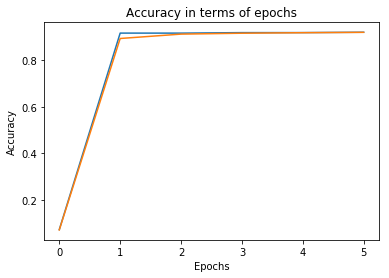

In [16]:
dim_input = 28*28
dim_output = 10

network = LinearNetwork(dim_input, dim_output)
optimizer = SGD(network.parameters(), 0.01)

training_loop(network, optimizer, train_data, dev_data, n_epochs=5)

After you finished the linear network, you can move to a deep network!
The tanh argument can be used to switch between relu or tanh. Warning: use the correct initialization for a given activation!

In [17]:
class DeepNetwork(Module):
    def __init__(self, dim_input, dim_output, hidden_dim, n_layers, Tanh=False):
        self.W = ModuleList()
        self.b = ModuleList()
        
        # TODO
        self.Tanh = Tanh
        if self.Tanh:
            self.activation_function = tanh
        else:
            self.activation_function = relu
            print(5)
        
        for i in range(n_layers):
            self.W.append(Parameter(np.ndarray((hidden_dim, dim_input))))
            self.b.append(Parameter(np.ndarray((hidden_dim))))
            
        self.output_proj =  Parameter(np.ndarray((dim_output, hidden_dim))) # TODO# TODO
        self.output_bias = Parameter(np.ndarray((dim_output)))# TODO
        
        self.init_parameters()
        
    def init_parameters(self):
        glorot_init(self.output_proj.data)
        zero_init(self.output_proj.data)
        
        for b in self.b:
            zero_init(b.data)
            
        if self.Tanh:
            for W in self.W:
                glorot_init(W.data)
        else: 
            for W in self.W:
                kaiming_init(W.data)

    def forward(self, x):
        # TODO
        z = x
        for W, b in zip(self.W , self.b):
            z = affine_transform(W, b, z)
            z = self.activation_function(z)

        z = affine_transform(self.output_proj, self.output_bias, z)
        return z

5
Before training accuracy is :  0.09976
Accuracy on dev data before training is : 0.096100
-----------------------
For epoch = 1 : Train accuracy is 0.919160 and Dev accuracy is 0.957100
For epoch = 2 : Train accuracy is 0.964800 and Dev accuracy is 0.967600
For epoch = 3 : Train accuracy is 0.976920 and Dev accuracy is 0.971000
For epoch = 4 : Train accuracy is 0.982640 and Dev accuracy is 0.973100
For epoch = 5 : Train accuracy is 0.987380 and Dev accuracy is 0.975200
For epoch = 6 : Train accuracy is 0.990700 and Dev accuracy is 0.974500
For epoch = 7 : Train accuracy is 0.993480 and Dev accuracy is 0.976700
For epoch = 8 : Train accuracy is 0.995140 and Dev accuracy is 0.976700
For epoch = 9 : Train accuracy is 0.996320 and Dev accuracy is 0.976500
For epoch = 10 : Train accuracy is 0.997640 and Dev accuracy is 0.976600
----------------------------
Accuracy on test data is 0.976200 


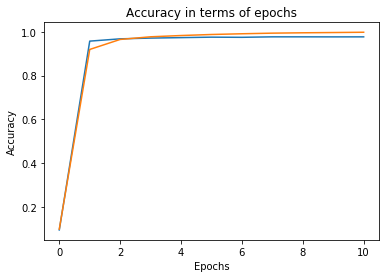

In [18]:
dim_input = 28*28
dim_output = 10

network = DeepNetwork(dim_input, dim_output, 100, 1, Tanh=False)
optimizer = SGD(network.parameters(), 0.01)

training_loop(network, optimizer, train_data, dev_data, n_epochs=10)

In [ ]:
dim_input = 28*28
dim_output = 10

network = DeepNetwork(dim_input, dim_output, 100, 1, Tanh=True)
optimizer = SGD(network.parameters(), 0.01)

training_loop(network, optimizer, train_data, dev_data, n_epochs=10)

Before training accuracy is :  0.09976
Accuracy on dev data before training is : 0.096100
-----------------------
For epoch = 1 : Train accuracy is 0.915520 and Dev accuracy is 0.954800
For epoch = 2 : Train accuracy is 0.960200 and Dev accuracy is 0.965400
For epoch = 3 : Train accuracy is 0.972680 and Dev accuracy is 0.968600
For epoch = 4 : Train accuracy is 0.980260 and Dev accuracy is 0.972100
For epoch = 5 : Train accuracy is 0.985740 and Dev accuracy is 0.974200
For epoch = 6 : Train accuracy is 0.989900 and Dev accuracy is 0.974000


# Bonus

You can try to implement a momentum SGD optimizer!
Note that you have to keep track of the velocity for each parameter in the optimizer.

In [39]:
# simple gradient descent optimizer
class SGD_optimizer:
    def __init__(self, params, epsilon=0.1, mu=0.1):
        self.params = params
        self.epsilon = epsilon
        self.mu = mu 
        
        
    def step(self):
        for p in self.params:
            p.gamma[:] = self.mu*p.gamma + p.gradient
            p.data[:] = p.data - self.epsilon* p.gamma

        
    def zero_grad(self):
        for p in self.params:
            p.zero_grad()

Before training accuracy is :  0.09012
Accuracy on dev data before training is : 0.091500
-----------------------
For epoch = 1 : Train accuracy is 0.920000 and Dev accuracy is 0.960200
For epoch = 2 : Train accuracy is 0.961980 and Dev accuracy is 0.965300
For epoch = 3 : Train accuracy is 0.971960 and Dev accuracy is 0.966300
For epoch = 4 : Train accuracy is 0.979460 and Dev accuracy is 0.971600
For epoch = 5 : Train accuracy is 0.983460 and Dev accuracy is 0.972200
----------------------------
Accuracy on test data is 0.972900 


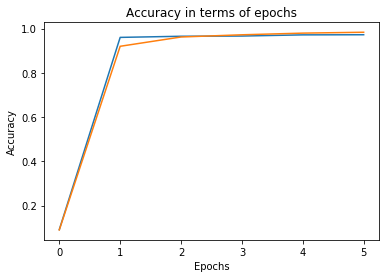

In [42]:
dim_input = 28*28
dim_output = 10

network = DeepNetwork(dim_input, dim_output, 100, 1, Tanh=True)
optimizer = SGD_optimizer(network.parameters(), 0.01, 0.5)

training_loop(network, optimizer, train_data, dev_data, n_epochs=5)